In [1]:
!pip install emoji
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

/home/kvnn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.
/home/kvnn/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
airlines_train = pd.read_csv("/home/kvnn/Desktop/TCS Mini Project/DataSet/Tweets.csv")

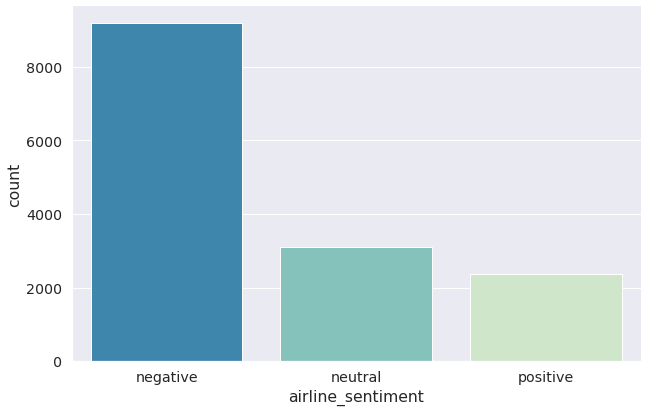

In [3]:
airlines_train = airlines_train.reindex(np.random.permutation(airlines_train.index))
airlines_train=airlines_train[['text', 'airline_sentiment']]

sns.factorplot(x="airline_sentiment", data=airlines_train, kind="count", size=6, aspect=1.5, palette="GnBu_r")
plt.show();

In [4]:
class CleanText (BaseEstimator, TransformerMixin):
     def remove_mentions(self, input_text):
          return re.sub(r'@\w+', '', input_text)
     
     def remove_urls(self, input_text):
          return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

     def emoji_oneword(self, input_text):
          return input_text.replace('_','')     

     def emoji_punctuation (self, input_text):
          return input_text.replace('_','')

     def remove_punctuation(self, input_text):
          punct = string.punctuation
          trantab = str.maketrans(punct, len(punct)*' ')
          return input_text.translate(trantab)
     def remove_digits(self, input_text):
          return re.sub('\d+', '', input_text)

     def to_lower(self, input_text):
          return input_text.lower()

     def remove_stopwords(self, input_text):
          stopwords_list = stopwords.words('english')
          whitelist = ["n't", "not", "no"]
          words = input_text.split()
          clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word)>1]
          return " ".join(clean_words)

     def stemming(self, input_text):
          porter = PorterStemmer ()
          words = input_text.split()
          stemmed_words = [porter.stem(word) for word in words]
          return " ".join(stemmed_words)

     def fit(self, X , y=None, **fit_params):
          return self

     def transform(self, X, **transform_params):
          clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits)
          return clean_X

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
ct=CleanText()
sr_clean = ct.fit_transform(airlines_train.text)
sr_clean.sample(5)
empty_clean=sr_clean==''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

[nltk_data] Downloading package punkt to /home/kvnn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kvnn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0 records have no words left after text cleaning


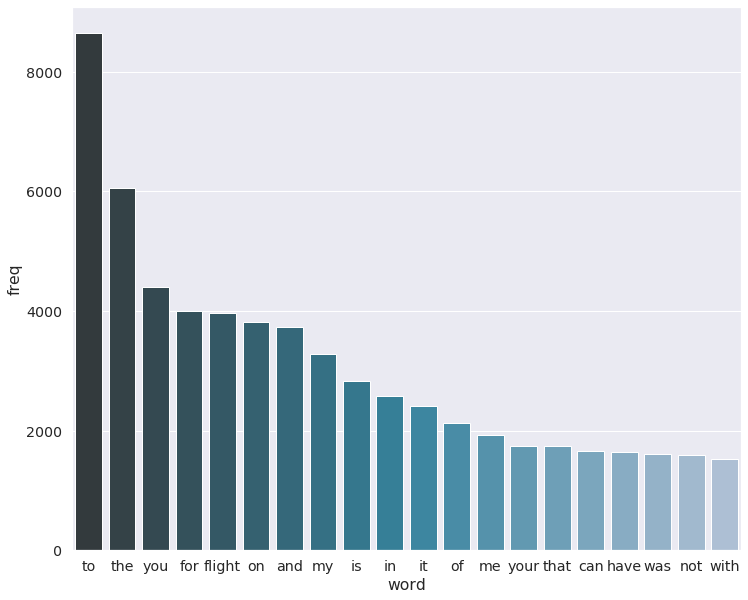

In [6]:
cv= CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax=plt.subplots(figsize=(12,10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [7]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)
    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [8]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}
# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}
# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [9]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self

In [10]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df
tc = TextCounts()
airlines_eda = tc.fit_transform(airlines_train.text)
airlines_eda['airline_sentiment'] = airlines_train.airline_sentiment

In [11]:
df_model = airlines_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()


['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'airline_sentiment',
 'clean_text']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment',axis=1),df_model.airline_sentiment,test_size=0.1, random_state=37)
mnb = MultinomialNB()
logreg = LogisticRegression()
countvect = CountVectorizer()
best_mnb_countvect = grid_vect (mnb, parameters_mnb, X_train, X_test, parameters_text = parameters_vect, vect=countvect)
best_logreg_countvect = grid_vect (logreg, parameters_logreg, X_train, X_test, parameters_text = parameters_vect, vect=countvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   44.6s finished


done in 46.525s

Best CV score: 0.791
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.805


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.82      0.94      0.87       911
     neutral       0.76      0.53      0.62       320
    positive       0.78      0.66      0.71       233

    accuracy                           0.80      1464
   macro avg       0.79      0.71      0.74      1464
weighted avg       0.80      0.80      0.79      1464

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.0min finished


done in 247.004s

Best CV score: 0.799
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.819


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.86      0.91      0.88       911
     neutral       0.73      0.64      0.68       320
    positive       0.77      0.72      0.75       233

    accuracy                           0.82      1464
   macro avg       0.78      0.76      0.77      1464
weighted avg       0.81      0.82      0.82      1464



In [13]:
tfidfvect = TfidfVectorizer()
print("MultinomialNB")
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
print("LogisticRegression")
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect
                              )

MultinomialNB
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   41.5s finished


done in 42.877s

Best CV score: 0.751
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.747


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.73      0.98      0.84       911
     neutral       0.81      0.30      0.44       320
    positive       0.81      0.44      0.57       233

    accuracy                           0.75      1464
   macro avg       0.78      0.57      0.62      1464
weighted avg       0.76      0.75      0.71      1464

LogisticRegression
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.2min finished


done in 250.989s

Best CV score: 0.766
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.764


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.79      0.93      0.85       911
     neutral       0.68      0.44      0.53       320
    positive       0.72      0.57      0.64       233

    accuracy                           0.76      1464
   macro avg       0.73      0.65      0.67      1464
weighted avg       0.75      0.76      0.75      1464

